In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time


In [3]:
# Read in the saved camera matrix and distortion coefficients
# Calculated in camera_calibration.py
dist_pickle = pickle.load(open("camera_cal/camera_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [4]:
#Source and destination points for perspective transformation. Obtained from an image with a straight lane
src=np.float32([(240,695),(595,450),(1070,695),(685,450)])
dest=np.float32([(300,720),(300,50),(1000,720),(1000,50)])

#Transform perspective from car interior to a top view
def warp(img):
    #undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    M = cv2.getPerspectiveTransform(src, dest)
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return warped
#Transform perspective from top view to car interior
def unwarp(img):
    M = cv2.getPerspectiveTransform(dest, src)
    unwarped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return unwarped

In [5]:
#Binarize image attempting to keep only pixels that are "lane candidates"
def binarize(img, s_thresh=(130, 255), sx_thresh=(15, 135)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

In [6]:
#Apply camera distortion removal, perspective transformation and binarization to an image
def top_view_binarized(img):
    undistorted = undistort(img)
    binarized = binarize(undistorted)
    return warp(binarized)

In [7]:
#Detect lanes in a top view image
#Returns fitted curves for left and right lanes
def lanes_from_windows(img):
    # Take a histogram of the bottom half of the binary top-view image
    histogram = np.sum(img[img.shape[0] // 2:, :], axis=0)
    # Find peaks around the expected position of the lane lines (~300, 1000)
    leftx_base = np.argmax(histogram[240:360]) + 240
    rightx_base = np.argmax(histogram[940:1060]) + 940
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2, full=True)
    right_fit = np.polyfit(righty, rightx, 2, full=True)

    return left_fit, right_fit

In [8]:
#Detect lanes in a top view image, using previously detected lane curves as a starting point
#Returns new fitted curves
def lanes_from_previous(img, left_fit, right_fit):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 25
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                                   left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                         left_fit[1] * nonzeroy + left_fit[
                                                                             2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                           right_fit[1] * nonzeroy + right_fit[
                                                                               2] + margin)))
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2, full=True)
    right_fit = np.polyfit(righty, rightx, 2, full=True)

    return left_fit, right_fit

In [9]:
#Draw lane in an image, optionally adding a text at the top
def draw_lane(img,left_fit,right_fit, text=""):
    #Create empty lane canvas
    lane_img = np.zeros_like(img)
    #Generate line points
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    left_line_points = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((left_line_points, right_line_points))
    #Color the area enclosed by the lanes
    cv2.fillPoly(lane_img, np.int_([lane_pts]), (0,255,0))
    #Transform lane image to car interior perspective
    lane_img=unwarp(lane_img)
    #Overlay lane on original (camera) image
    composite=cv2.addWeighted(img,1,lane_img,0.3,0)
    #Write text on top of the final image
    cv2.putText(composite,text,(200,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    return composite  

In [10]:
#Initialize global variables needed during video process
def initialize_processing():
    global max_residual, curverad
    max_residual=10**10
    curverad=None
    position=None

In [11]:
def find_lane_lines(img):
    global left_fit, right_fit, max_residual
    if max_residual>10**7:
        #If the fit is not satisfactory, detect lane lines with sliding window algorithm
        left_fit,right_fit = lanes_from_windows(img)
    else:
        #If the fit is not so bad, detect lane lines within a margin of the previous lines
        left_fit,right_fit = lanes_from_previous(img,left_fit[0],right_fit[0])
    max_residual=max(left_fit[1][0],right_fit[1][0])
    #Return the fitted lines
    return left_fit[0], right_fit[0]

In [12]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

#Estimate lane road curvature radius at 'y_eval' vertical coordinate, and car position relative to the center of the lane
def estimate_curvature_and_position(left_fit,right_fit,y_eval=720,img_width=1280):
    global curverad,position
    #Curve parameters scaled in meters
    scaled_a_left=xm_per_pix / (ym_per_pix ** 2) * left_fit[0]
    scaled_b_left=xm_per_pix / ym_per_pix * left_fit[1]
    scaled_a_right=xm_per_pix / (ym_per_pix ** 2) * right_fit[0]
    scaled_b_right=xm_per_pix / ym_per_pix * right_fit[1]
    scaled_c_right=xm_per_pix / ym_per_pix 
    #Radius estimation from curve 
    left_curverad = ((1 + (2*scaled_a_left*y_eval + scaled_b_left)**2)**1.5) / np.absolute(2*scaled_a_left)
    right_curverad = ((1 + (2*scaled_a_right*y_eval + scaled_b_right)**2)**1.5) / np.absolute(2*scaled_a_right)
    current_curverad=np.mean((left_curverad,right_curverad))
    #Lane line positions
    leftx=left_fit[0] * y_eval ** 2 + left_fit[1] * y_eval + left_fit[2]
    rightx=right_fit[0] * y_eval ** 2 + right_fit[1] * y_eval + right_fit[2]

    lane_center_px=leftx+(rightx-leftx)/2
    #Car position in pixel scale (image center - lane center)
    position_px=img_width/2-lane_center_px
    #Car position in meters
    current_position=position_px*xm_per_pix
    
    if curverad is None:
        #If no previous values are available, use current
        curverad=current_curverad
        position=current_position
    else:
        #Smooth output if previous values are available
        curverad=curverad*0.9+current_curverad*0.1
        position=position*0.9+current_position*0.1
    return curverad, position

In [13]:
def curvature_and_position_text(radius,position):
    if position<-0.1:
        position_text='Position: {:0.1f}m left of lane center'.format(-position)
    else:
        if position>0.1:
            position_text='Position: {:0.1f}m right of lane center'.format(position)
        else:
            position_text='Position: around lane center'
            
    if curverad>10000:
        curve_text='Curve Radius: >10Km'
    else:
        curve_text = 'Curve Radius: {:0.1f}Km '.format(curverad/1000)
        
    return curve_text+position_text

In [14]:
def process_image(img):
    binary_top_view = top_view_binarized(img)
    left_fit, right_fit = find_lane_lines(binary_top_view)
    curverad, position = estimate_curvature_and_position(left_fit, right_fit, y_eval=img.shape[0]/2, img_width=img.shape[1])
    #text='Left: {:06,.0f} Right: {:06,.0f}'.format(left_fit[1][0], right_fit[1][0])
    return draw_lane(img,left_fit,right_fit, curvature_and_position_text(curverad,position))

In [14]:
initialize_processing()
output_video = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image)
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [05:58<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 13min 9s, sys: 27 s, total: 13min 36s
Wall time: 6min


In [ ]:
initialize_processing()
output_video = 'output_videos/challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
output_clip = clip1.fl_image(process_image)
%time output_clip.write_videofile(output_video, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clip))

In [23]:
def show_two(img,img2, caption_one="Original",caption_two="Result"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title(caption_one, fontsize=40)

    ax2.imshow(img2, cmap="gray")
    ax2.set_title(caption_two, fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

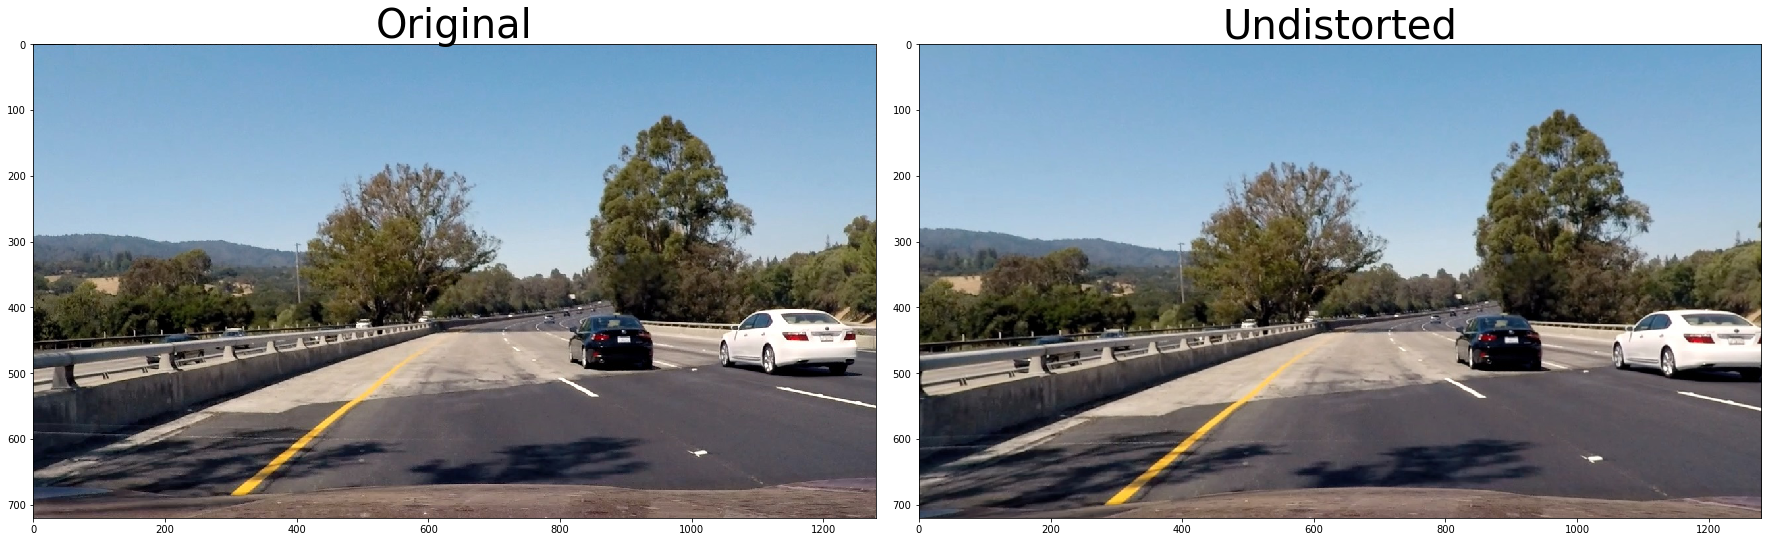

In [16]:
img=mpimg.imread('test_images/test4.jpg')
show_two(img,undistort(img),caption_two="Undistorted")

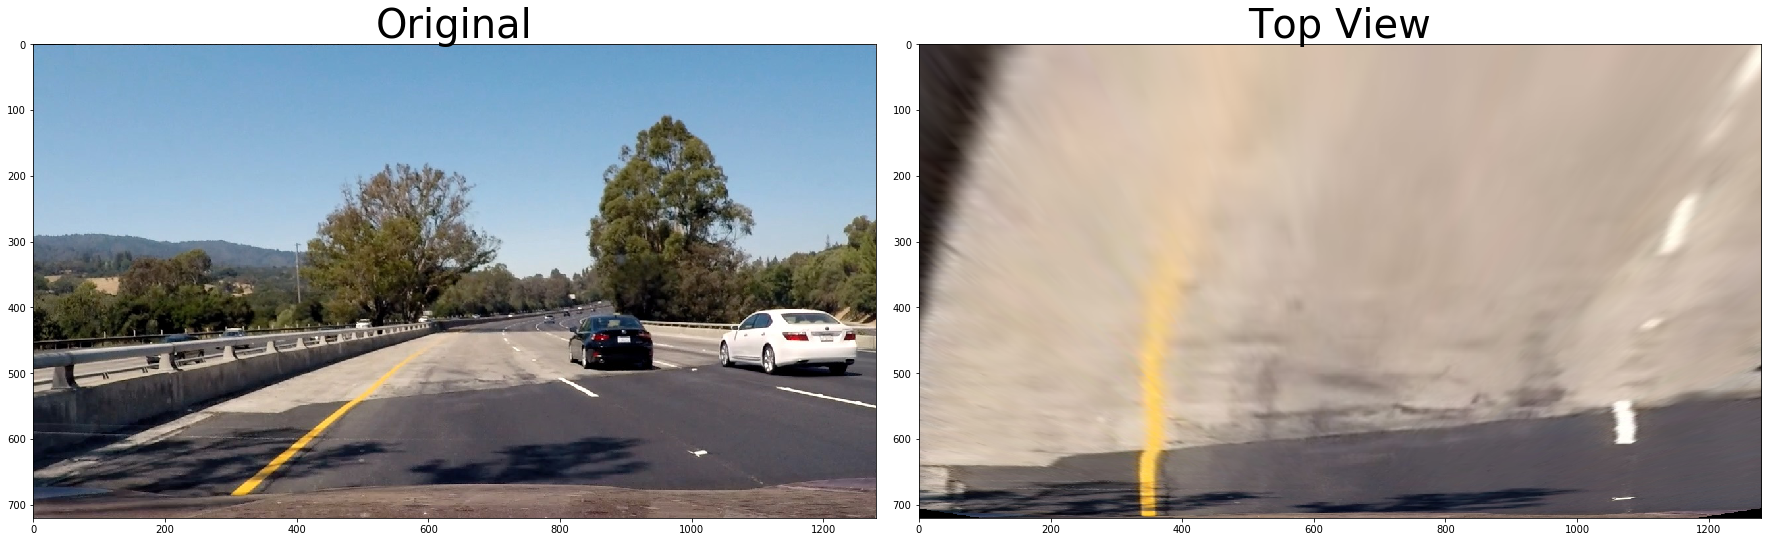

In [17]:
show_two(img,warp(img),caption_two="Top View")

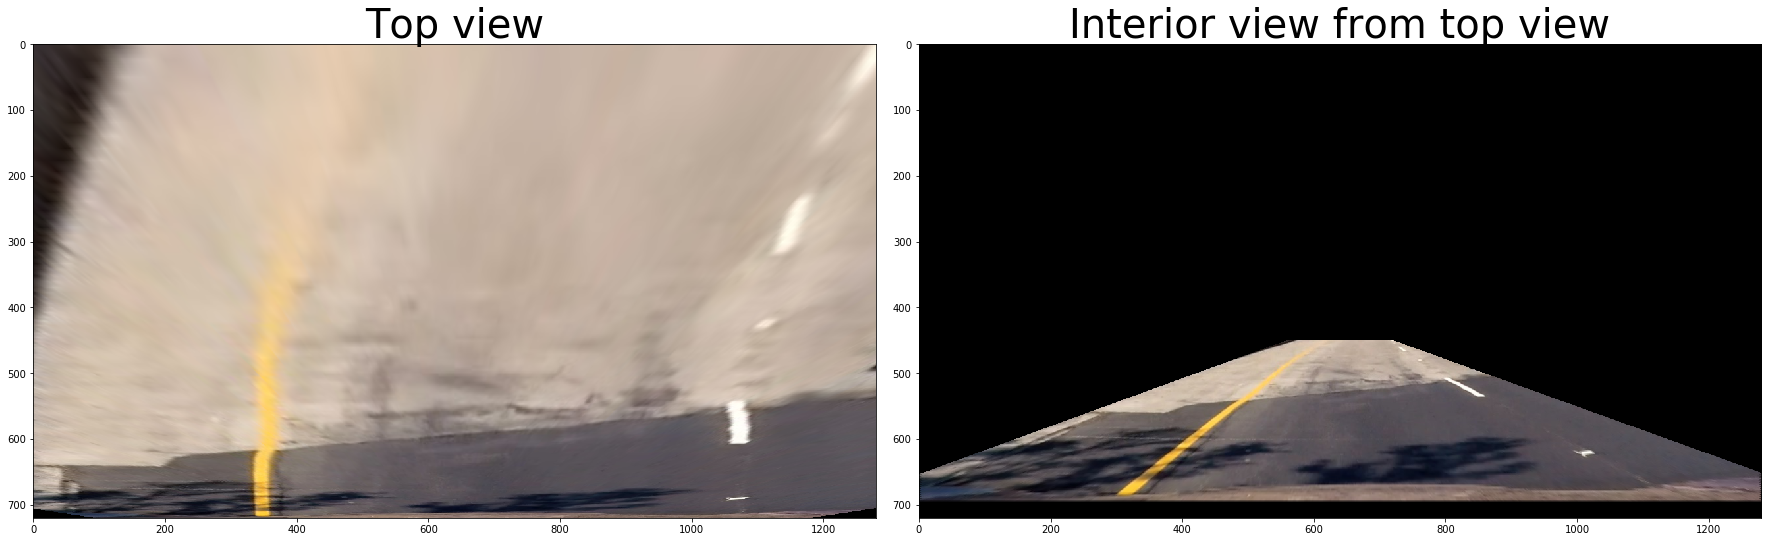

In [18]:
show_two(warp(img),unwarp(warp(img)),caption_one="Top view",caption_two="Interior view from top view")

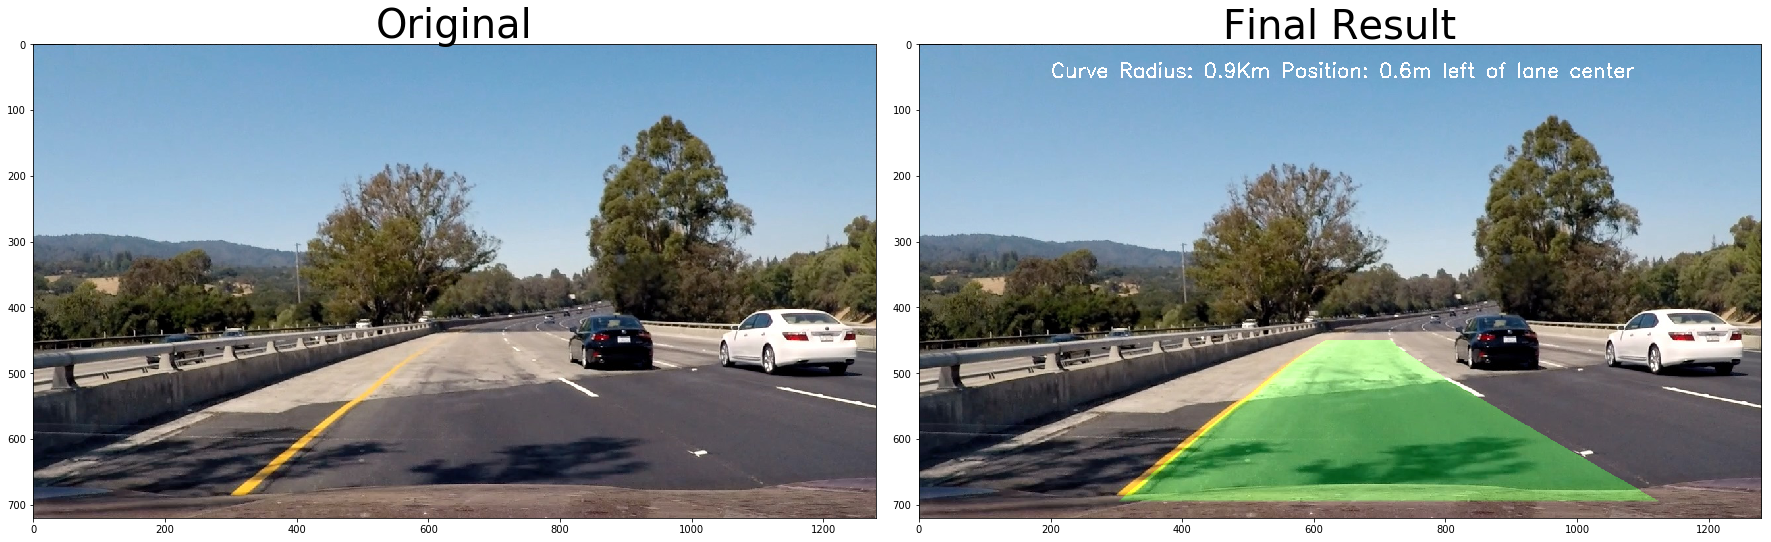

In [19]:
initialize_processing()
img = mpimg.imread('test_images/test4.jpg')
show_two(img,process_image(img),caption_two="Final Result")

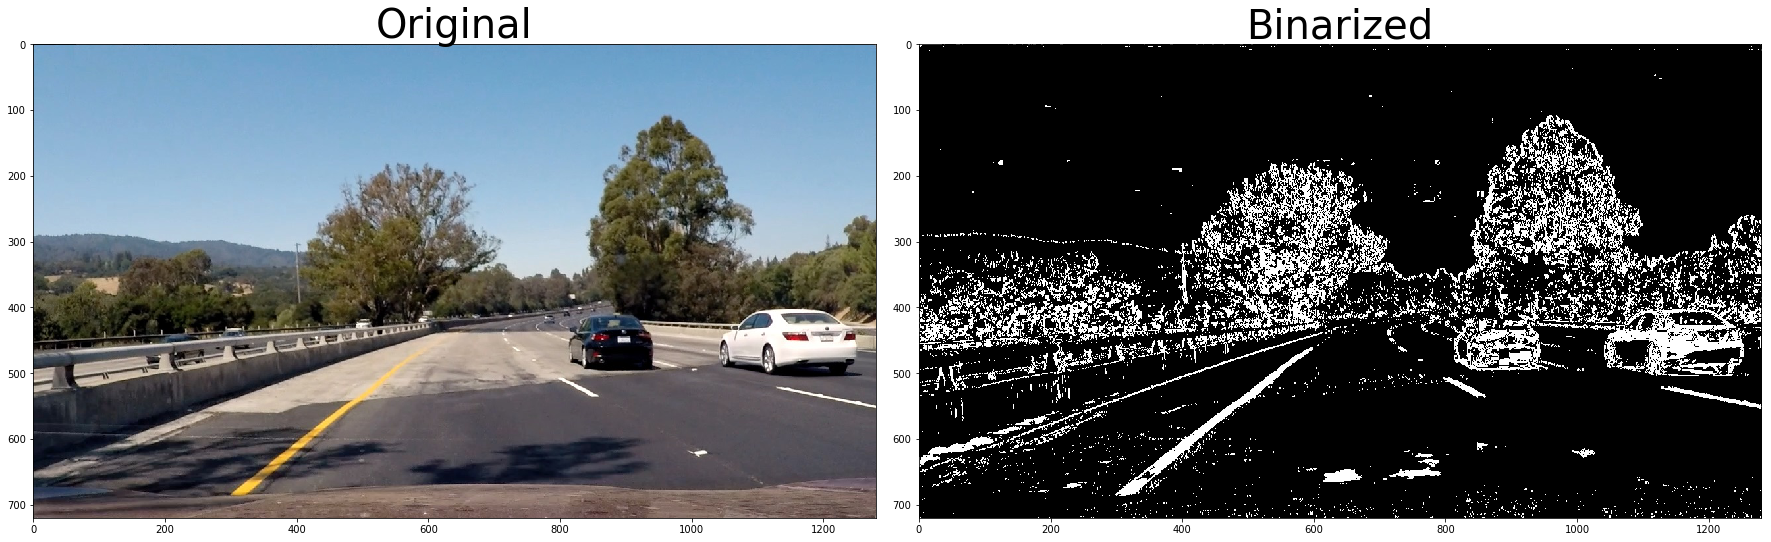

In [25]:
show_two(img,binarize(img),caption_two="Binarized")

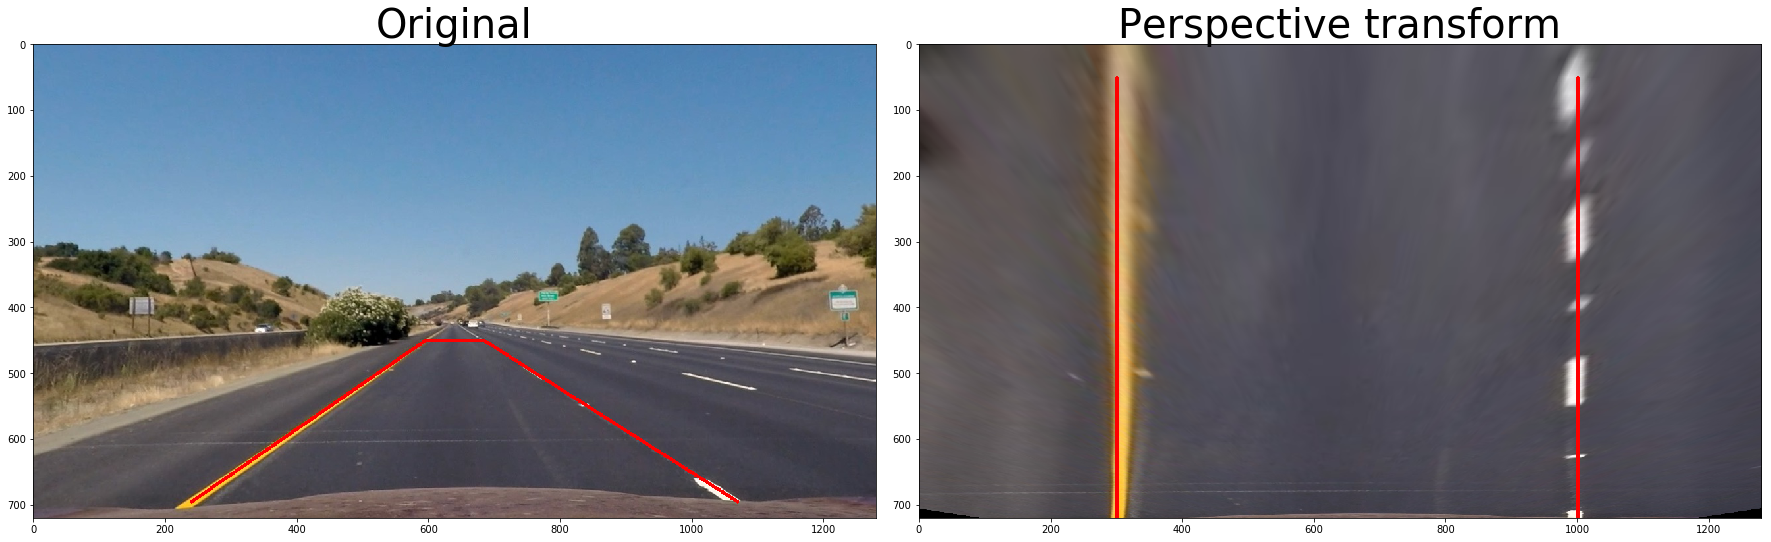

In [29]:
img = mpimg.imread('test_images/straight_lines1_undistorted.jpg')
warped=warp(img)
cv2.line(img,(240,695),(595,450),(255,0,0),4)
cv2.line(img,(1070,695),(685,450),(255,0,0),4)
cv2.line(img,(595,450),(685,450),(255,0,0),4)

cv2.line(warped,(300,720),(300,50),(255,0,0),4)
cv2.line(warped,(1000,720),(1000,50),(255,0,0),4)
show_two(img,warped,caption_two="Perspective transform")